In [27]:
#load the modules
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
import pandas as pd
import shapely.geometry as geometry

In [266]:
def add_edge(edges, edge_points, coords, i, j):
    """
    Add a line between the i-th and j-th points,
    if not in the list already
    """
    if (i, j) in edges or (j, i) in edges:
        # already added
        return edges.add( (i, j) )
    edge_points.append(coords[[i, j]])

In [267]:
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    coords = np.array([point for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [268]:
from descartes import PolygonPatch
def plot_polygon(polygon,margin_x = 100, margin_y = 50):
    '''
    input the polygon and margin output the polygon circle the points in th
    '''
    fig, ax = plt.subplots(figsize=(10,10))
    margin_x = margin_x
    margin_y = margin_y
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin_x, x_max+margin_x])
    ax.set_ylim([y_min-margin_y, y_max+margin_y])
    patch = PolygonPatch(polygon, fc='#f6d55c',
                         ec='grey', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

In [257]:
points = pd.read_csv('points_x_y.csv',index_col= 0)

In [375]:
points.head()
sample_point_Z = points.loc[points.Z == 15,]

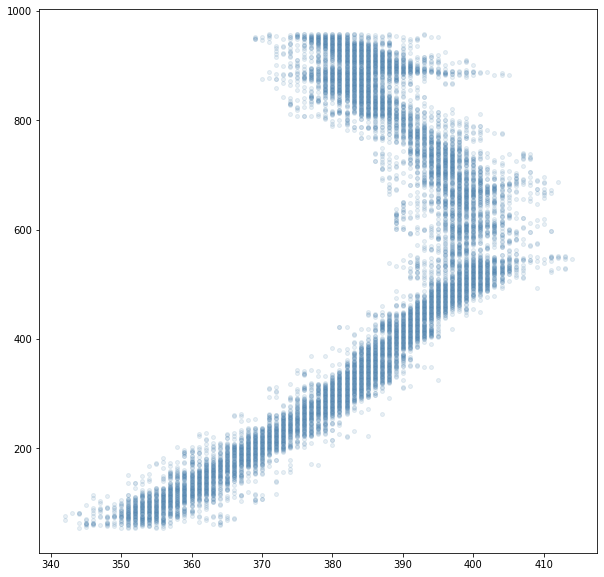

In [376]:
#lets see how points look like 
import matplotlib.pylab as plt
plt.figure(figsize=(10,10))
_ = plt.plot(sample_point_Z.col, sample_point_Z.row,'o',color='#20639B',alpha = 0.1, markersize = 4)

In [377]:
points_list = [list(sample_point_Z.iloc[i,0:2]) for i in range(len(sample_point_Z))]
x = [p[0] for p in points_list]
y = [p[1] for p in points_list]

# Need to take a look at this envelope

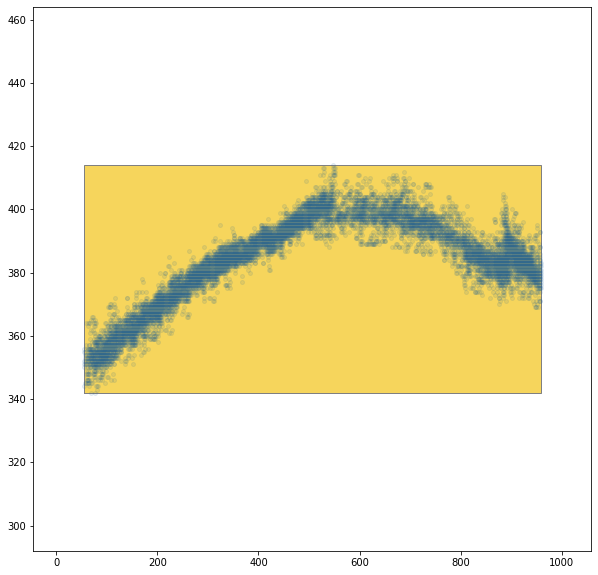

In [385]:
point_collection = geometry.MultiPoint(points_list)
_ = plot_polygon(point_collection.envelope)
_ = plt.plot(x,y,'o', color='#20639B',markersize = 4,alpha = 0.1)

# Boundaries is not supposed to be so uniform and straight, so we will naturally led to experiment with the CONVEX HULL of the points.

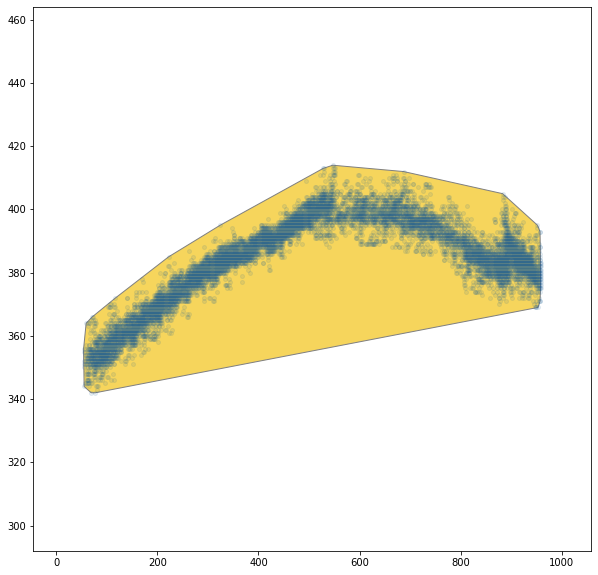

In [386]:
convex_hull_polygon = point_collection.convex_hull
_ = plot_polygon(convex_hull_polygon)
_ = plt.plot(x,y,'o', color='#20639B',markersize = 4,alpha = 0.1)

In [398]:
sam_points_list = random.sample(points_list,math.floor(0.1*len(points_list)))

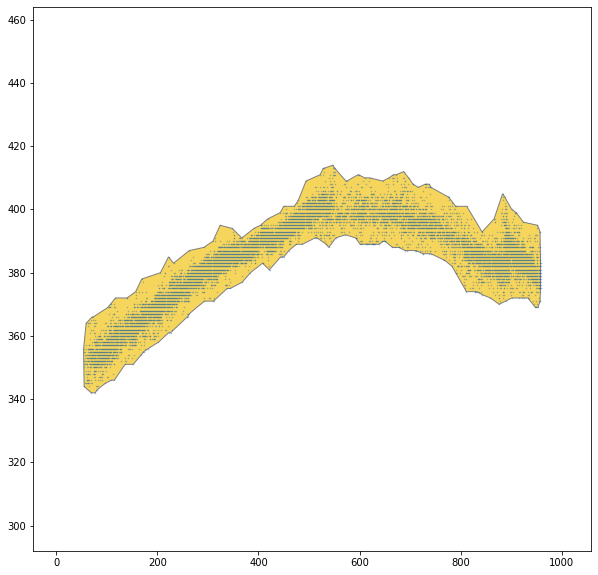

In [433]:
concave_hull, edge_points = alpha_shape(points_list, alpha=0.018)
_ = plot_polygon(concave_hull)
_ = plt.plot(x,y,'o', color='#20639B',markersize = 0.5,alpha = 0.4)

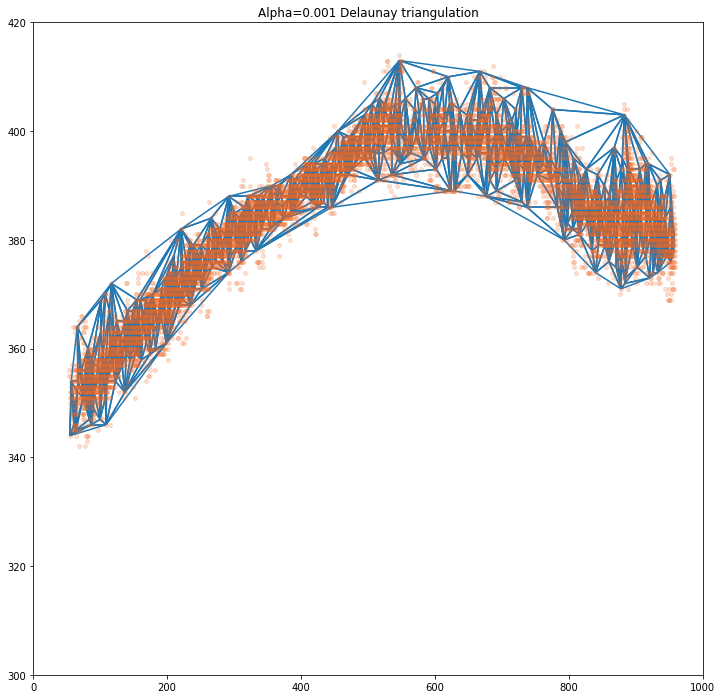

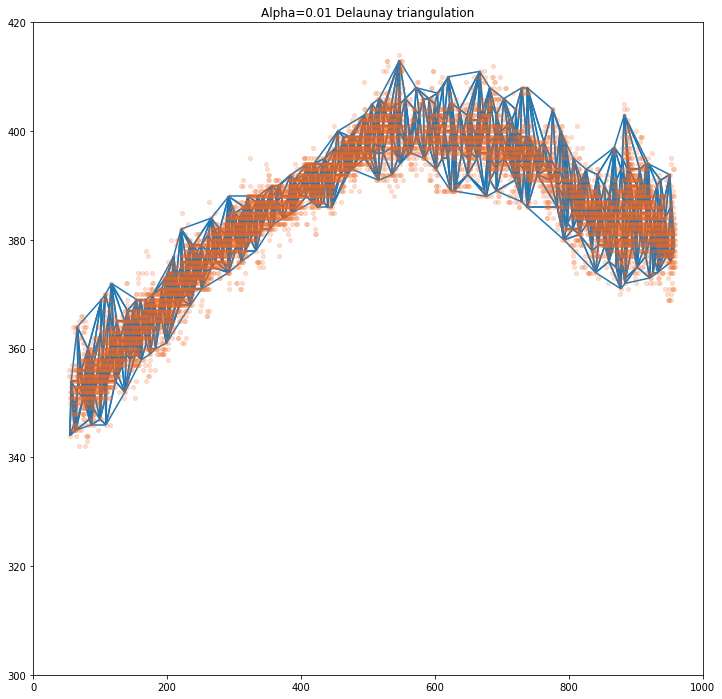

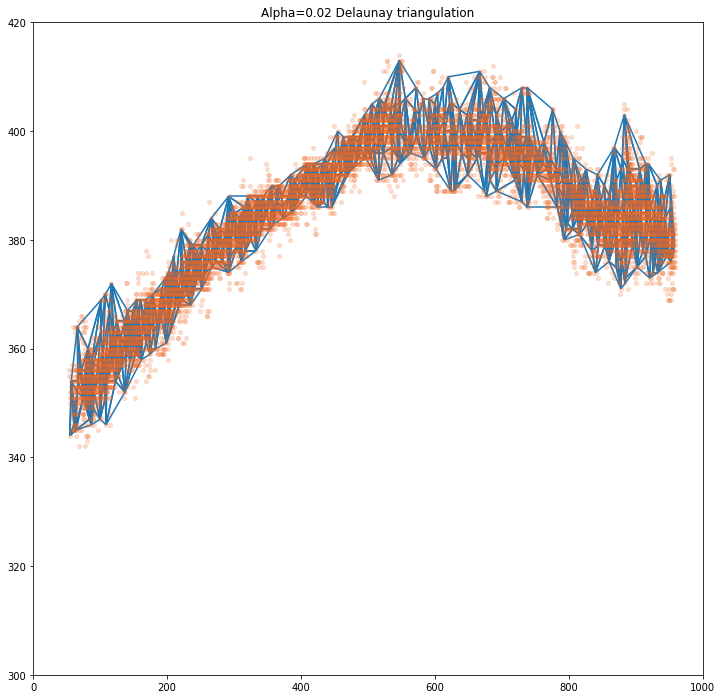

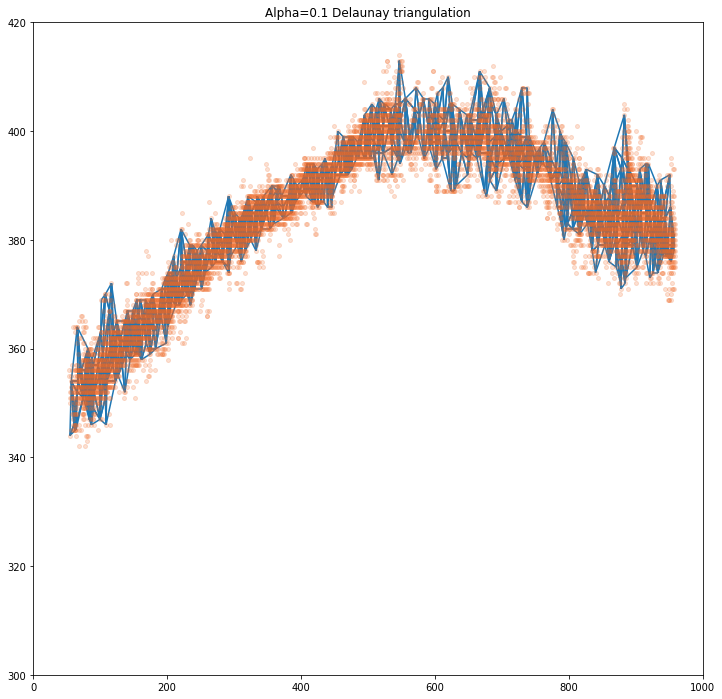

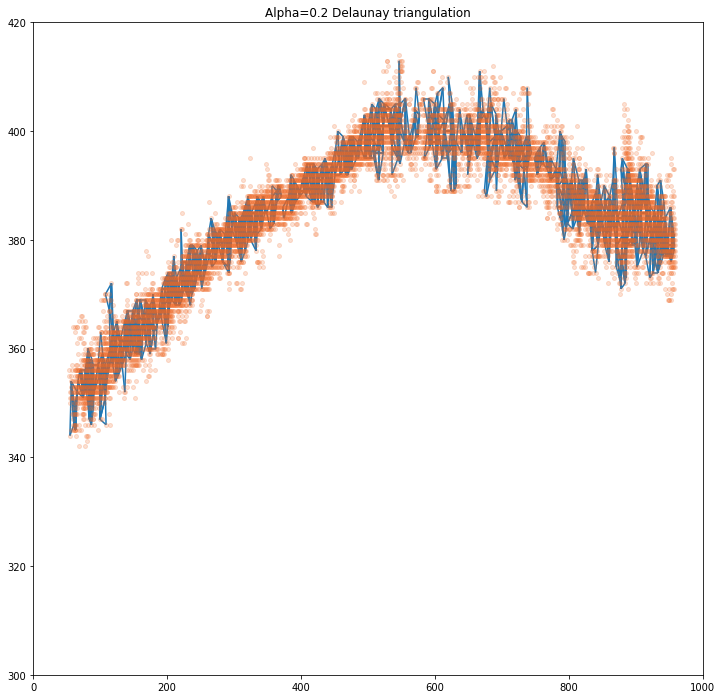

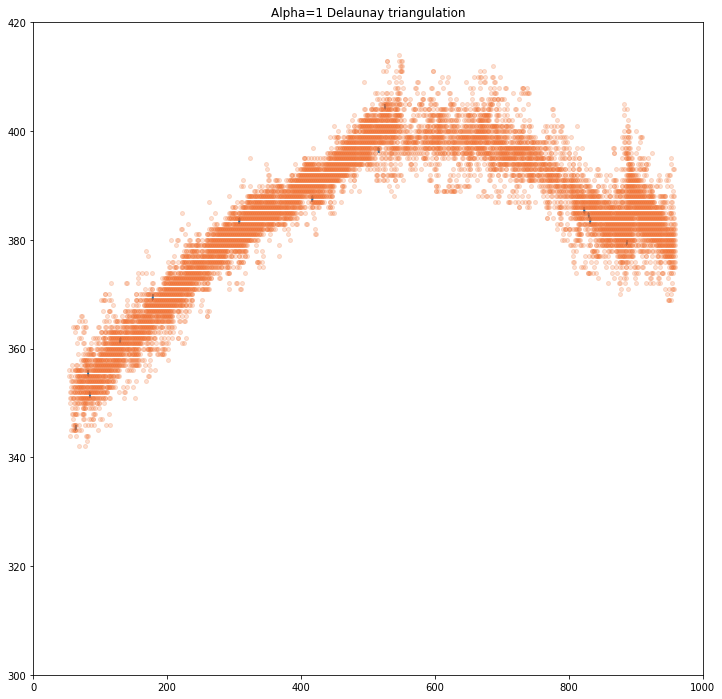

In [423]:
from matplotlib.collections import LineCollection
alpha_list = [0.001,0.01,0.02,0.1,0.2,1]
for i in alpha_list:
    concave_hull, edge_points = alpha_shape(sam_points_list, alpha=i)
    lines_to_plot = LineCollection(edge_points)
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xlim(0, 1000)
    ax.set_ylim(300, 420)
    ax.set_title('Alpha={0} Delaunay triangulation'.format(i))
    ax.add_collection(lines_to_plot)
    plt.plot(delaunay_points[:,0], delaunay_points[:,1],'o', color='#f16824', markersize = 4, alpha = 0.2)
    plt.show()

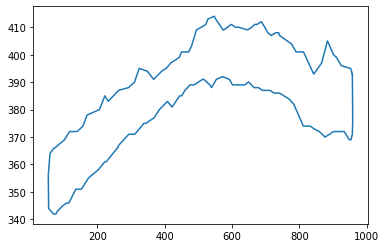

In [442]:
plt.plot(concave_hull.exterior.xy[0], concave_hull.exterior.xy[1],'-')

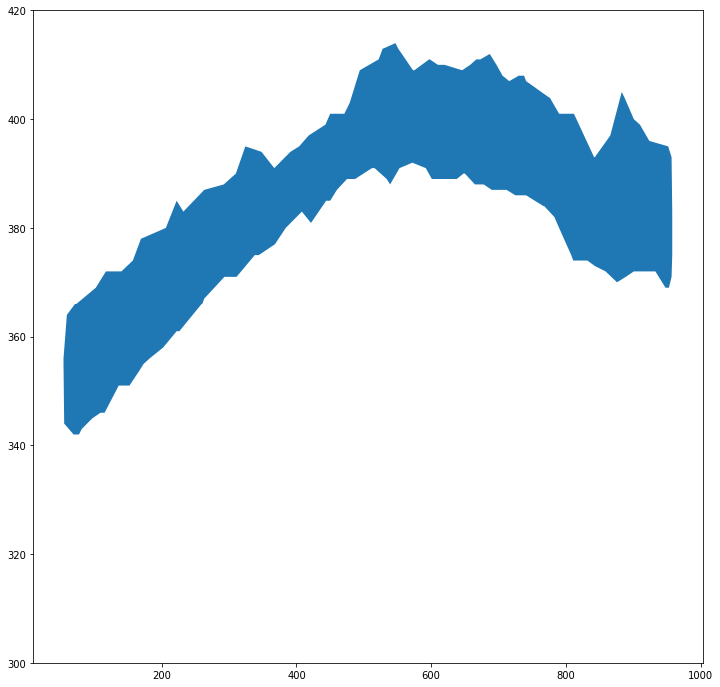

In [448]:
#get the exterior points of the graph
fig,ax = plt.subplots(figsize=(12, 12))
ax.fill(concave_hull.exterior.xy[0], concave_hull.exterior.xy[1])
ax.set_ylim(300, 420);